In [1]:
using Pkg
Pkg.activate("..")
using Revise
using Gen
using DataFrames
using Logging
using Plots

  Activating project at `~/src/mit/BayesAir.jl`


In [2]:
using BayesAir

In [36]:
global_logger(ConsoleLogger(stderr, Logging.Info));

In [140]:
# Define a simple schedule sending the aircraft back and forth between two airports
states = Vector{BayesAir.NetworkState}()
for _ in 1:1
    flight_schedule = DataFrame(
        :flight_number => ["F1", "F2"],
        :origin => ["BOS", "JFK"],
        :destination => ["JFK", "BOS"],
        :scheduled_departure_time => [0.0, 2.0],
        :scheduled_arrival_time => [1.0, 3.5],
        :actual_departure_time => [0.0 + rand() * 0.3, 2.0 + rand() * 0.3],
        :actual_arrival_time => [1.0 + rand() * 0.3, 3.5 + rand() * 0.3],
    )
    flights, airports = BayesAir.parse_schedule(flight_schedule)
    push!(airports[1].available_aircraft, 0.0)
    push!(airports[1].available_crew, 0.0)

    airport_dict = Dict{String, BayesAir.Airport}()
    for airport in airports
        airport_dict[airport.code] = airport
    end

    state = BayesAir.NetworkState(airport_dict, flights |> Vector{BayesAir.Flight})
    push!(states, state)
end

In [141]:
# Trace the simulation using Gen and see the random choices made by the simulator
hrs = 10.0
dt = 0.1
trace = Gen.simulate(BayesAir.simulate, (states, hrs, dt));
Gen.get_choices(trace)

│
├── ("BOS", :service_time) : 0.09940669661165091
│
├── :travel_time_variation : 0.04727630361083505
│
├── :turnaround_time_variation : 0.08066569463421974
│
├── :measurement_variation : 0.01837305386772218
│
├── ("BOS", "JFK", :travel_time) : 4.1263237516407045
│
├── ("JFK", :turnaround_time) : 0.7258798060711685
│
├── ("JFK", "BOS", :travel_time) : 4.167092734415709
│
├── ("BOS", :turnaround_time) : 0.020211235118159032
│
├── ("JFK", :service_time) : 0.06058468055252959
│
└── (:day, 1)
    │
    ├── ("F1 BOS->JFK", :actual_arrival_time) : 4.278102706780851
    │
    ├── ("F1 BOS->JFK", :actual_departure_time) : 0.031162519931985752
    │
    ├── ("F2 JFK->BOS", :actual_departure_time) : 5.295377076963994
    │
    ├── ("F2 JFK->BOS", :actual_arrival_time) : 9.618130421884967
    │
    ├── ("F2 JFK->BOS", :arrival_service_time) : 0.11920466554163195
    │
    ├── ("F1 BOS->JFK", :departure_service_time) : 0.028031565055859874
    │
    ├── ("F2 JFK->BOS", :departure_service_time) : 0

In [142]:
# Define a function for doing posterior inference. can we back out the travel times?
# Let's start by using dead-simple importance sampling
function do_importance_sampling(model, states, hrs, dt, num_samples)
    # Create a choice map that maps the actual departure and arrival times to the
    # observed values.
    observations = Gen.choicemap()
    for (i, state) in enumerate(states)
        for flight in state.pending_flights
            observations[(:day, i) => (BayesAir.flight_code(flight), :actual_departure_time)] = flight.actual_departure_time
            observations[(:day, i) => (BayesAir.flight_code(flight), :actual_arrival_time)] = flight.actual_arrival_time
        end
    end
    
    # Call importance_resampling to obtain a likely trace consistent
    # with our observations.
    (traces, log_norm_weights, _) = Gen.importance_sampling(model, (states, hrs, dt), observations, num_samples);
    return traces, log_norm_weights
end;

In [154]:
function render_traces(traces, weights=nothing)
    # Make a scatter plot of the travel times for each trace
    bos_jfk_travel_times = Vector{Float64}()
    jfk_bos_travel_times = Vector{Float64}()
    for trace in traces
        push!(bos_jfk_travel_times, trace[("BOS", "JFK", :travel_time)])
        push!(jfk_bos_travel_times, trace[("JFK", "BOS", :travel_time)])
    end

    # Make a histogram of the travel time, using weights if provided
    if !isnothing(weights)
        fig = histogram2d(
            bos_jfk_travel_times,
            jfk_bos_travel_times;
            bins=(100, 100),
            weights=weights,
            xlabel="BOS -> JFK",
            ylabel="JFK -> BOS",
            legend=false,
            colorbar=true,
            show_empty_bins=true,
            color=:plasma,
            xlims = (0,6),
            ylims = (0,6)
        )
    else
        fig = scatter(
            bos_jfk_travel_times,
            jfk_bos_travel_times;
            xlabel="BOS -> JFK",
            ylabel="JFK -> BOS",
            legend=false,
            xlims = (0,6),
            ylims = (0,6)
        )
    end

    return fig
end;

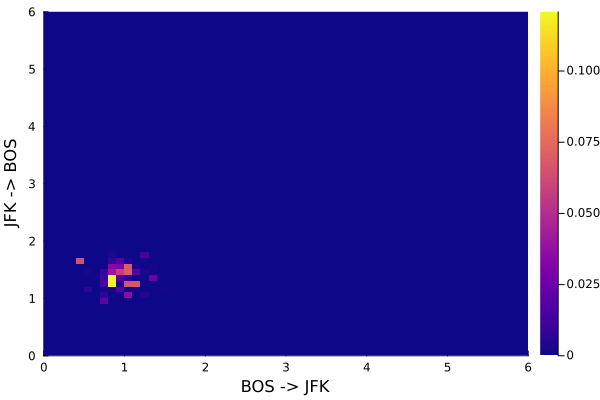

In [412]:
traces, log_weights = do_importance_sampling(BayesAir.simulate, states, 24.0, dt, 100000)
render_traces(traces, exp.(log_weights))

In [388]:
@gen function system_parameter_proposal(trace, width = 0.1)
    # Resample the system parameters
    {:measurement_variation} ~ uniform(
        max(0.0, trace[:measurement_variation] - width / 2),
        min(trace[:measurement_variation] + width / 2, 0.1)
    )
    {:travel_time_variation} ~ uniform(
        max(0.0, trace[:travel_time_variation] - width / 2),
        min(trace[:travel_time_variation] + width / 2, 0.1)
    )
    {:turnaround_time_variation} ~ uniform(
        max(0.0, trace[:turnaround_time_variation] - width / 2),
        min(trace[:turnaround_time_variation] + width / 2, 0.1)
    )
end

@gen function airport_parameter_proposal(trace, airport_code::BayesAir.AirportCode, width = 0.1)
    # Resample the parameters for the given airport
    {(airport_code, :turnaround_time)} ~ uniform(
        max(0.0, trace[(airport_code, :turnaround_time)] - width / 2),
        min(trace[(airport_code, :turnaround_time)] + width / 2, 1.0)
    )
    {(airport_code, :service_time)} ~ uniform(
        max(0.0, trace[(airport_code, :service_time)] - width * 0.1 / 2),
        min(trace[(airport_code, :service_time)] + width * 0.1 / 2, 0.1)
    )
end

@gen function all_airport_parameter_proposal(trace, airport_codes, width = 0.1)
    for airport_code in airport_codes
        {*} ~ airport_parameter_proposal(trace, airport_code, width)
    end
end

@gen function travel_times_proposal(trace, airport_codes, width = 0.1)
    # Resample mean travel times for all routes
    nominal_travel_times = Dict{Tuple{BayesAir.AirportCode, BayesAir.AirportCode}, Float64}()
    for origin_code in airport_codes
        for destination_code in airport_codes
            if origin_code != destination_code
                key = (origin_code, destination_code, :travel_time)
                nominal_travel_times[(origin_code, destination_code)] = {key} ~ uniform(
                    max(0.0, trace[key] - width * 0.1 / 2),
                    min(trace[key] + width * 0.1 / 2, 6.0)
                )
            end
        end
    end

    # # Resample actual travel times for all routes
    # for (i, state) in enumerate(Gen.get_args(trace)[1])
    #     for flight in state.pending_flights
    #         key = (:day, i) => (BayesAir.flight_code(flight), :travel_time)
    #         {key} ~ normal(
    #             nominal_travel_times[(flight.origin, flight.destination)],
    #             nominal_travel_times[(flight.origin, flight.destination)] * trace[:travel_time_variation]
    #         )
    #     end
    # end
end

@gen function high_level_proposal(trace, airport_codes, width = 0.1)
    {*} ~ system_parameter_proposal(trace, width)
    {*} ~ all_airport_parameter_proposal(trace, airport_codes, width)
    {*} ~ travel_times_proposal(trace, airport_codes, width)
end

function resimulate_service_times(trace, airport_codes, constraints)
    # Re-simulate the schedule while keeping system and airport parameters fixed
    low_level_keys = Vector{Any}()
    for (i, state) in enumerate(Gen.get_args(trace)[1])
        for flight in state.pending_flights
            push!(low_level_keys, (:day, i) => (BayesAir.flight_code(flight), :departure_service_time))
            push!(low_level_keys, (:day, i) => (BayesAir.flight_code(flight), :travel_time))
            push!(low_level_keys, (:day, i) => (BayesAir.flight_code(flight), :arrival_service_time))
        end
    end

    # Resimulate all other random parameters
    (trace, accepted) = mh(trace, Gen.select(low_level_keys...), check=true, observations=constraints)

    return trace, accepted
end

function gaussian_drift_update(trace, width, constraints)
    # Get a list of all airports
    airport_codes = keys(Gen.get_args(trace)[1][1].airports)

    (trace, system_params_accepted) = mh(trace, system_parameter_proposal, (width,), check=true, observations=constraints)
    (trace, airport_params_accepted) = mh(trace, all_airport_parameter_proposal, (airport_codes, width), check=true, observations=constraints)
    (trace, travel_times_accepted) = mh(trace, travel_times_proposal, (airport_codes, 100.0 * width), check=true, observations=constraints)

    # Resimulate each flight's parameters
    departure_service_accepted = 0.0
    travel_time_accepted = 0.0
    arrival_service_accepted = 0.0
    num_flights = 0
    for (i, state) in enumerate(Gen.get_args(trace)[1])
        for flight in state.pending_flights
            (trace, accepted) = mh(trace, Gen.select((:day, i) => (BayesAir.flight_code(flight), :departure_service_time)), check=true, observations=constraints)
            departure_service_accepted += accepted

            (trace, accepted) = mh(trace, Gen.select((:day, i) => (BayesAir.flight_code(flight), :travel_time)), check=true, observations=constraints)
            travel_time_accepted += accepted

            (trace, accepted) = mh(trace, Gen.select((:day, i) => (BayesAir.flight_code(flight), :arrival_service_time)), check=true, observations=constraints)
            arrival_service_accepted += accepted

            num_flights += 1
        end
    end

    return trace, Dict(
        :system_params => system_params_accepted,
        :airport_params => airport_params_accepted,
        :travel_times => travel_times_accepted,
        :departure_service => departure_service_accepted / num_flights,
        :travel_time => travel_time_accepted / num_flights,
        :arrival_service => arrival_service_accepted / num_flights,
    )
end;

function do_mcmc_inference(model, states, hrs, dt, num_samples, burn_in_samples=100, width=0.1)
    # Make constraints based on actual departure and arrival times
    constraints = Gen.choicemap()
    for (i, state) in enumerate(states)
        for flight in state.pending_flights
            constraints[(:day, i) => (BayesAir.flight_code(flight), :actual_departure_time)] = flight.actual_departure_time
            constraints[(:day, i) => (BayesAir.flight_code(flight), :actual_arrival_time)] = flight.actual_arrival_time
        end
    end

    # Get an initial trace
    (trace, _) = Gen.generate(model, (states, hrs, dt), constraints)

    # Run the burn-in
    for _ in 1:burn_in_samples
        trace, _ = gaussian_drift_update(trace, width, constraints)
    end

    # Run the main loop
    scores = Vector{Float64}()
    traces = Vector{Gen.DynamicDSLTrace}()
    acceptance_rates = Dict()
    for _ in 1:num_samples
        trace, accepted = gaussian_drift_update(trace, width, constraints)
        push!(traces, trace)
        push!(scores, Gen.get_score(trace))

        # Update acceptance rates
        for (key, value) in accepted
            if !haskey(acceptance_rates, key)
                acceptance_rates[key] = 0.0
            end

            acceptance_rates[key] = acceptance_rates[key] + value / num_samples
        end
    end

    return traces, scores, acceptance_rates
end;

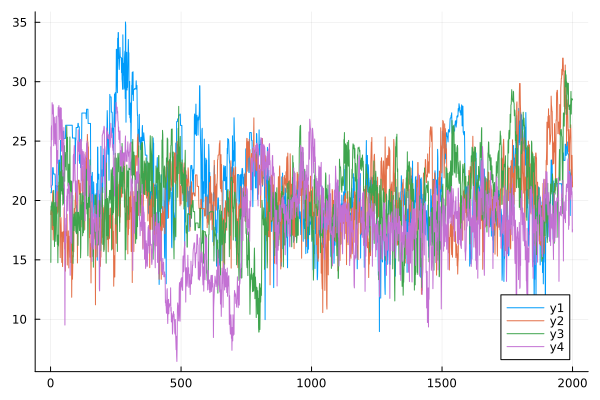

In [408]:
all_traces = Vector{Any}()
trace_figs = Vector{Plots.Plot{Plots.GRBackend}}()
scores = Vector{Vector{Float64}}()
average_acceptance_rates = Dict()
n_chains = 4
for _ in 1:n_chains
    traces, trace_scores, acceptance_rates = do_mcmc_inference(BayesAir.simulate, states, 24.0, dt, 2000, 2000, 0.1)
    push!(trace_figs, render_traces(traces))
    push!(all_traces, traces)
    push!(scores, trace_scores)
    for (key, value) in acceptance_rates
        if !haskey(average_acceptance_rates, key)
            average_acceptance_rates[key] = 0.0
        end
        average_acceptance_rates[key] = average_acceptance_rates[key] + value / n_chains
    end
end
Plots.plot([s for s in scores])

In [410]:
average_acceptance_rates

Dict{Any, Any} with 6 entries:
  :travel_times      => 0.042
  :airport_params    => 0.70575
  :travel_time       => 0.540625
  :system_params     => 0.2965
  :arrival_service   => 0.517812
  :departure_service => 0.197688

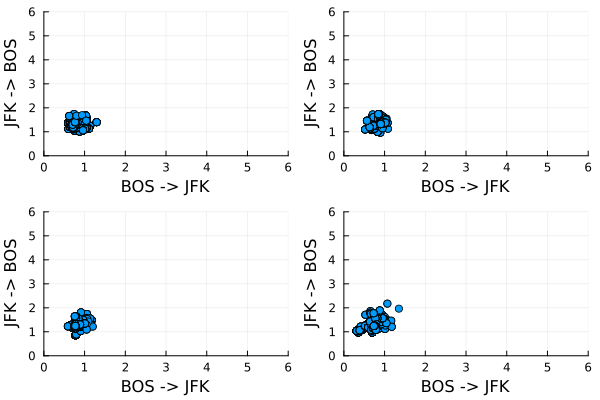

In [411]:
Plots.plot(trace_figs...)